**First step: Go to the "runtime" field in google collab and in "change runtime type" select the GPU.**

**Connenction to google drive**

Click the "play" button to run the cell. You will be connected to your personal google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Set working directory's path**


Open the "file folder" on the right and navigate into the drive folder in order to find the EMODNET folder.Then by clicking the three dots next to EMODNET folder, copy the path. Delete the existing path in the os.chdir below before "models/.." and then paste yours to conclude in something like: os.chdir(r"/your path/EMODnet/models/roberta")

In [ ]:
#Change the path with the location of the folder in your drive
import os #library that provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc.
os.chdir(r"/content/drive/Shareddrives/Advance/Workspace/Melina_Loulakaki/EMODnet/models/spacy")

**Load required python libraries for further use**

A Python library is a reusable chunk of code that you may want to include in your programs/ projects. e.g pandas library is for data analysis

In [ ]:
import spacy
import pandas as pd
import json
import re
import random
import spacy.cli
from spacy.tokens import DocBin
from tqdm import tqdm

#import entity ruler from spacy in order to add the dictionaries to the model
from spacy.pipeline import EntityRuler
from spacy.lang.en import English

**Convert ubiai IOB format into spacy format input**

The annotations from UBIAI tool were downloaded in [IOB format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)#:~:text=The%20IOB%20format%20(short%20for,named%2Dentity%20recognition).) and with the custom script below were converted into spacy ner annotation format, e.g   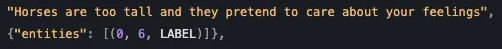

In [ ]:
#before upload and read the annotations (.tsv) file, delete the first raw (-DOCSTART- -X- O O) of the file 
import re
import pandas as pd

#reads the annotated data into variables, train_all, dev_all, eval_all respectively
train_all = pd.read_csv("data/training_IOBall.tsv", sep='\t+', header=None, engine='python') 
dev_all = pd.read_csv("data/development_IOBall.tsv", sep='\t+', header=None, engine='python')
eval_all = pd.read_csv("data/evaluation_IOBall.tsv", sep='\t+', header=None, engine='python')

#this function converts the data from IOB format to Spacy format.it takes a dataframe with two columns, the first one containing words and the second one containing IOB tags
#it returns a list of tuples with a sentence and a dictionary of entities in the Spacy format
def iob_to_spacy(df):
    words = df[0]
    tags = df[1]
    total_words = len(words)
    data = []
    data_i = 0
    i = 0

    sentence = ""
    sentence_len = 0
    sentence_entities = []
    for word in words:
        dot_index = word.find('.')
        if (dot_index != -1):
            # found in dot_index position
            if (dot_index == len(word)-1):
                # last char
                # check the 1st letter in the next word
                if (total_words-1 > i):
                    # exists in next word
                    # check if the first letter is capital 
                    if (words[i+1][0].isupper()):
                        sentence += word
                        if (tags[i] != 'O'):
                            entity = (sentence_len, len(sentence), tags[i])
                            sentence_entities.append(entity)
                        sentence_len = len(sentence)
                        new_val = (sentence, {"entities": sentence_entities})
                        data.append(new_val)
                        sentence = ""
                        sentence_len = 0
                        sentence_entities = []
                    else:
                        sentence += word + " "
                        if (tags[i] != 'O'):
                            entity = (sentence_len, len(sentence), tags[i])
                            sentence_entities.append(entity)
                        sentence_len = len(sentence)
        else:
            sentence += word + " "
            if (tags[i] != 'O'):
                entity = (sentence_len, len(sentence), tags[i])
                sentence_entities.append(entity)
            sentence_len = len(sentence)
        i += 1
    #combines IOB format entities that are more than one word into one string-phrase with the entity's name 
    for sent in data:
        entities = sent[1]['entities']
        new_entities = []
        entity_start = 0
        entity_end = 0
        entity_type = ""
        for entity in entities:
            if entity[2][0] == "B":
                if entity_end != 0:
                    new_entity = (entity_start, entity_end, entity_type)
                    new_entities.append(new_entity)
                entity_start = entity[0]
                entity_end = entity[1]
                entity_type = entity[2]
            else:
                entity_end = entity[1]
        if entity_end != 0:
            new_entity = (entity_start, entity_end, entity_type)
            new_entities.append(new_entity)
            sent[1]['entities']=new_entities

    for sent in data:
        entity_start = 0
        entity_end = 0
        entity_type = ""
        new_entities=[]
        for entity in sent[1]['entities']:
            entity_start = entity[0]
            entity_end = entity[1]
            entity_type = entity[2]
            entity_type=re.sub(r'.', '', entity_type , count = 2)
            new_entity = (entity_start, entity_end, entity_type)
            new_entities.append(new_entity)
            sent[1]['entities']=new_entities
    return data

#calls the previous script and saves the training, development and evaluation converted data into variables, train_fulltext, dev_fulltext, eval_fulltext respectively
train_fulltext=iob_to_spacy(train_all)
dev_fulltext=iob_to_spacy(dev_all)
eval_fulltext=iob_to_spacy(eval_all)


**Dictionaries load**

Created dictionaries for distribution discriptors, life stages, body size and sampling devices are placed in the models' folder as .csv files.

In [ ]:
#read the dictionaries into variables df,df1,df2,df3 as pandas dataframes
#read_csv() function imports a CSV file to DataFrame format
df=pd.read_csv("dictionaries/Distribution_descriptors.csv",header=None)
df1=pd.read_csv("dictionaries/Life_stages.csv",header=None)
df2=pd.read_csv("dictionaries/Body_size.csv",header=None)
df3=pd.read_csv("dictionaries/Sampling_devices.csv",header=None,encoding='cp1252')

#keeps the first column of each dictionary into variables to have the ability to access them later
df_distr_descr=df.iloc[:,0]
df_life_stages=df1.iloc[:,0]
df_body_size=df2.iloc[:,0]
df_sampl_devices=df3.iloc[:,0]


**Creates the nlp variable with the ner pipe and adds the labels-entities**

In order to train a model for named entity recognision with custom entities, the blank english spacy model needs to be loaded in a variable. 

In [ ]:
#setting the blank english model to the nlp variable 
nlp=spacy.blank("en")

#create and add ner into the nlp model's pipeline if it does not exist
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe('ner')

#add labels-entities to ner, entities are the labels for the information we want to extract from texts
ner.add_label("DISTRIBUTION_DESCRIPTOR")
ner.add_label("LIFE_STAGE")
ner.add_label("BODY_SIZE")
ner.add_label("SAMPLING_DEVICE")
ner.labels #prints the ner's labels just added


**Convert data into .spacy [doc bin file](https://spacy.io/api/docbin)**

This is a Python function that takes in two arguments: train_data, which is a list of training examples, and name, which is a string that will be used as the filename when the training data is saved in the desired format.

In [ ]:
#import the required package
from spacy.util import filter_spans

#converting data into .spacy doc bin file
#for each sentence in training data it makes the convertion into doc bin and keeping the entities.
def training_data_format(train_data,name):
    doc_bin = DocBin() #creates an instance of a spaCy DocBin object, which is used to efficiently serialize and deserialize large amounts of spaCy Doc objects.
    for training_example in tqdm(train_data): # iterates over each training example in train_data, which is assumed to be a tuple where the first element is the text of the example and the second element is a dictionary containing the entity labels for the example.
        text = training_example[0]
        labels = training_example[1]['entities']
        doc = nlp.make_doc(text) #extracts the text and entity labels and creates a spaCy Doc object using the make_doc method of the nlp object
        ents = []
        for start, end, label in labels:# iterates over each entity label in the example and creates a spaCy Span object corresponding to the entity. If the span is None, the function skips the entity, otherwise it adds the span to a list of ents
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        filtered_ents = filter_spans(ents) #filters the spans using the filter_spans function, which is a utility function provided by spaCy that merges overlapping and adjacent spans and removes duplicates.
        doc.ents = filtered_ents 
        doc_bin.add(doc)
    
    return(doc_bin.to_disk(spacy_data/"train_" + name + ".spacy")) #saves the converted file to disk (to working directories'path)

#calls the script above for each dataset and after converting it into .spacy doc bin file saves it into the path of the working directory
training_data_format(train_fulltext,"train_full")
training_data_format(dev_fulltext,"dev_full")
training_data_format(eval_fulltext,"eval_full")


**Initialization of the configuration file**

Training config files include all settings and hyperparameters for training the pipeline, such as the number of epochs (an "epoch" refers to a full iteration over the entire training dataset.. Instead of providing lots of arguments on the command line, you only need to pass the config.cfg

In [ ]:
#load locale library. Locale may be a string, or an iterable of two strings (language code and encoding).
import locale
locale.getpreferredencoding = (lambda *args: 'UTF-8') #sets the encoding to UTF-8

#base.config configuration file initiallization and config.cfg fill for training
!python -m spacy init fill-config config_files/base_config.cfg config_files/config.cfg

**Model Training**

In order to train the pipeline uses the train command of spacy.

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' #command for error fixing

#donwloading the en_core_web_lg spacy model
!python -m spacy download en_core_web_lg #ISWS DE XREIAZETAI, NA DW VECTORS

#this command is using the spaCy library to train a new language model using the configuration file config.cfg. The training data will be loaded from train_train_full.spacy and the development/validation data from train_dev_full.spacy.
#you can set additional command-line options starting with -- that correspond to the config section and value to override. For example, --paths.train ./corpus/train.spacy sets the train value in the [paths] block.
!python -m spacy train config_files/config.cfg --output ./ --paths.train ./spacy_data/train_train_full.spacy --paths.dev ./spacy_data/train_dev_full.spacy
#after training is complete, the trained model is saved in the working directory as model-best and model-last, using the model-best
#If you want to keep the trained model and not overwrite it if you choose to train another one, after training is complete go to the folder of the project in your working directory and rename it 

**Model's Evaluation**

This command is using the spaCy library to evaluate the performance of a trained language model on a validation dataset loaded from the train_eval_full.spacy file. The model being evaluated is the one that performed best during training and was saved as model-best.

In [ ]:
#evaluation of trained model 
!python -m spacy evaluate model-best ./spacy_data/train_eval_full.spacy

**Model's Performance Testing**

In this section the trained model is loaded as an nlp variable and tested in an example text. The output result is the extracted entities founded by the model in the text.

In [ ]:
from spacy import displacy #import displacy for visualise the result

#load trained model into nlp_full variable
nlp_full=spacy.load("model-best") 
#put the text you want to extract entities into the nlp_full(" "), it will be saved to the doc variable
doc=nlp_full("Atherinids are small marine, estuarine and freshwater fishes not exceeding 120 mm SL (a soon to be described species of Craterocephalus may reach 300 mm SL), occurring predominantly in the Old World, with only Alepidomus evermanni (freshwaters of Cuba) and two marine species, Atherinomorus stipes and Hypoatherina harringtonensis (predominantly in the shore waters of the Caribbean) known from the New World. I")

print([(ent.text, ent.label_ ,ent.start_char, ent.end_char, ent.ent_id_) for ent in doc.ents]) #prints the text, the entity-label, the start char, the end char and an id link of extracted entities, if it exists
print("\n")

displacy.render(doc, style="ent") #call displacy render in order to visualise the resulted entities


**Add dictionaries to the [entity ruler](https://spacy.io/api/entityruler)**

In order to improve the model, dictionaries are added in the pipeline with the help of the entity ruler.

In [ ]:
#import tokenizer from spacy and save it in the tokenizer variable
from spacy.tokenizer import Tokenizer
tokenizer = nlp.tokenizer

#script in order to put the entity_ruler with dictionaries into ner pipeline
#entity ruler's patterns(entities) evaluate only if they are not annotaded in training data, so the ”entity_ruler” will only add new entities that match to the patterns only if they don’t overlap with existing entities predicted by the statistical model
def entity_ruler(nlp_model,model):
    if "entity_ruler" not in nlp_model.pipe_names:
        ruler=nlp_model.add_pipe("entity_ruler")
    else:
        ruler=nlp_model.get_pipe("entity_ruler")

    #script for adding the desirable patterns of dictionaries' entries into the entity ruler pipe
    def dict_func(df,linkdf,label):
        patterns=[]
        j=0
        for i in df:
            dict={"label": label}
            dict["pattern"]=[{"LOWER" : str.lower(i)}]
            #in order to take the id link of dictionaries's entities if exists, for now it is commented out cause there are not links for all the entities
            # dict["id"]=linkdf[[1]][1][j]
            patterns.append(dict)
            tokens=tokenizer(i)
            if len(tokens) == 2:
                dict={"label": label}
                dict["pattern"]=[{"LOWER" : str.lower(str(tokens[0]))}, {"IS_PUNCT": True}, {"LOWER" : str.lower(str(tokens[1]))}]
                # dict["id"]=linkdf[[1]][1][j]
                patterns.append(dict)
            j=j+1
        ruler.add_patterns(patterns)
    #calls dict func to add the dictionaries
    dict_func(df_distr_descr,df,"DISTRIBUTION_DESCRIPTOR")
    dict_func(df_life_stages,df1,"LIFE_STAGE")
    dict_func(df_body_size,df2,"BODY_SIZE")
    dict_func(df_sampl_devices,df3,"SAMPLING_DEVICE")

    #puts entity ruler into the trained model pipeline
    nlp_model.to_disk(model)

nlp_full=spacy.load("model-best")#loads the trained model
entity_ruler(nlp_full,"model-best_ruler")#calls the entity_ruler script and saves the model with entity ruler in the name of model-best_ruler



**Model Evaluation after dictionaries addition**

This command is using the spaCy library to evaluate the performance of a trained language model on a validation dataset loaded from the train_eval_full.spacy file. The model being evaluated was saved as model-best_ruler.

In [ ]:
#evaluation of trained model with entity ruller
!python -m spacy evaluate model-best_ruler/ ./spacy_data/train_eval_full.spacy

**Model's Performance Testing**

In this section the trained model is loaded as an nlp variable and tested in an example text. The output result is the extracted entities founded by the model in the text.

In [ ]:
from spacy import displacy #import displacy for visualise the result

#load trained model into nlp_full variable
nlp_full=spacy.load("model-best_ruler") 
#put the text you want to extract entities into the nlp_full(" "), it will be saved to the doc variable
doc=nlp_full("Atherinids are small marine, estuarine and freshwater fishes not exceeding 120 mm SL (a soon to be described species of Craterocephalus may reach 300 mm SL), occurring predominantly in the Old World, with only Alepidomus evermanni (freshwaters of Cuba) and two marine species, Atherinomorus stipes and Hypoatherina harringtonensis (predominantly in the shore waters of the Caribbean) known from the New World. I")

print([(ent.text, ent.label_ ,ent.start_char, ent.end_char, ent.ent_id_) for ent in doc.ents]) #prints the text, the entity-label, the start char, the end char and an id link of extracted entities, if it exists
print("\n")

displacy.render(doc, style="ent") #call displacy.render in order to visualise the resulted entities